<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_R/blob/main/Colab_Notebook/02_07_01_01_survival_analysis_kaplan_meier_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![All-test](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 1.1 Kaplan-Meier Estimator


This tutorial provides a hands-on introduction to the Kaplan-Meier estimator, a key non-parametric method in survival analysis. We'll use the `lung` dataset from the `survival` package in R, which contains data from a clinical trial on lung cancer patients. The tutorial is structured to guide you step-by-step, from theory to practical implementation. By the end, you'll be able to compute survival estimates, plot survival curves, and interpret results.


## Overview


The **Kaplan-Meier estimator** is a non-parametric statistic used to estimate the survival function from time-to-event data. It is particularly valuable when some data points are **censored**, meaning the event of interest (e.g., death, equipment failure) has not occurred for some subjects at the end of the study period.


The survival function $S(t)$ estimates the probability that an individual survives beyond time $t$. The Kaplan-Meier estimator provides a step function that drops at each event time (e.g., death, failure). The survival probability at a given time is calculated as:

$$
\hat{S}(t) = \prod_{t_i \leq t} \left( \frac{n_i - d_i}{n_i} \right)
$$

Where:

- $t_i$ is the time of the $i$-th event (e.g., death).
- $n_i$ is the number of subjects still at risk just before time $t_i$.
- $d_i$ is the number of events (e.g., deaths) at time $t_i$.
- The product of the ratios $\frac{n_i - d_i}{n_i}$ across all event times up to $t$ gives the estimated survival probability at time $t$.


### Features of Kaplan-Meier Estimation


-   **Non-parametric**: The Kaplan-Meier estimator does not assume any specific distribution of the survival times.
-   **Stepwise Survival Curve**: The survival curve is a step function that drops at each event time and stays flat between events.
-   **Censoring**: The Kaplan-Meier method can handle right-censored data, where we do not observe the event of interest for some subjects by the time the study ends. Censoring is denoted by ticks on the survival curve, showing the points where individuals were lost to follow-up or their event had not occurred by the study's end.


### Kaplan-Meier Survival Curve Interpretation


-   The curve starts at 1 (100% survival probability) and decreases over time as events occur. At each event time (e.g., death or failure), the curve steps down.
-   The **Y-axis** shows the estimated survival probability, and the **X-axis** represents time.
-   The rate of decline in the curve reflects the frequency of events (e.g., if there is a rapid decline, the event is occurring more frequently).
-   **Censored data** points are marked with tick marks or other indicators along the curve. These represent individuals who did not experience the event during the study but were lost to follow-up or had not yet experienced the event at the end of the study.



## Setup R in Python Runtype - Install {rpy2}
{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [1]:
!pip uninstall rpy2 -y
! pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.1
Uninstalling rpy2-3.5.1:
  Successfully uninstalled rpy2-3.5.1
  Using cached rpy2-3.5.1-cp312-cp312-linux_x86_64.whl


## Mount Google Drive

In [2]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Kaplan-Meier Esimator from Scratch


This is a manual calculation of the **Kaplan-Meier** estimator, without using any external R packages. The steps involve create a dataset, determining the number of individuals at risk, calculating the survival probability at each event time, and then plotting the results. You can compare these manually calculated results with those obtained from {estimation} analysis packages to verify accuracy. This exercise help you to understand theory behind **Kaplan-Meier** estimation.

***Steps***:

-   **Create a dataset**: We'll created a simulated dataset similar to the `lung` dataset in the {survival} package.

-   **Sort Data by Time**: Organize the dataset based on event times.

-   **Calculate Risk Set and Survival Probabilities**: For each unique event time, manually calculate the Kaplan-Meier survival probabilities.

-   **Plot the Kaplan-Meier Survival Curve**.


### Create a dataset


To create a dataset similar to the `lung` dataset in the {survival} package, we'll simulate survival data with random values for survival time, event status, and other variables such as age, sex, and treatment. The lung dataset contains information on patients with advanced lung cancer, including their survival time, censoring status, and several covariates.

Variables typically included in a survival dataset like **lung**:

1.  **time**: Survival time (numeric).

2.  **status**: Censoring indicator (0 = censored, 1 = event).

3.  **age**: Age of the patient (numeric).

4.  **sex**: Gender of the patient (1 = male, 2 = female).

5.  **ph.ecog**: ECOG performance score (0 to 5).

6.  **treatment**: Treatment group (1 = standard, 2 = experimental).


In [3]:
%%R

# Set the seed for reproducibility
set.seed(123)

# Number of observations
n <- 228  # same as the original lung dataset

# Simulate survival time (in days)
time <- round(runif(n, min = 1, max = 1000))  # random survival time between 1 and 1000 days

# Simulate censoring indicator (0 = censored, 1 = event)
status <- rbinom(n, size = 1, prob = 0.7)  # 70% of events, 30% censored

# Simulate age (between 40 and 80 years)
age <- round(runif(n, min = 40, max = 80))

# Simulate sex (1 = male, 2 = female)
sex <- sample(c(1, 2), size = n, replace = TRUE)

# Simulate ECOG performance score (0 to 4)
ph_ecog <- sample(0:4, size = n, replace = TRUE)

# Simulate treatment group (1 = standard, 2 = experimental)
treatment <- sample(c(1, 2), size = n, replace = TRUE)

# Create the data frame
simulated_lung<- data.frame(time = time,
                             status = status,
                             age = age,
                             sex = sex,
                             ph_ecog = ph_ecog,
                             treatment = treatment)

# Inspect the first few rows of the simulated dataset
head(simulated_lung)

  time status age sex ph_ecog treatment
1  288      1  72   1       4         2
2  789      0  70   2       0         2
3  410      1  46   2       2         2
4  883      1  45   1       1         2
5  941      1  79   2       2         2
6   47      1  57   1       3         2


### Sort data by time and event status


We need to sort the dataset by survival time


In [4]:
%%R
# Sort data by 'time'
simulated_lung <- simulated_lung[order(simulated_lung$time), ]
head(simulated_lung)

    time status age sex ph_ecog treatment
74     2      1  52   1       1         1
143   11      1  76   2       0         1
35    26      1  79   1       2         1
18    43      0  70   1       4         1
6     47      1  57   1       3         2
51    47      1  61   1       1         1


### Calculate Kaplan-Meier estimates


To calculate the Kaplan-Meier estimates manually, you can follow these steps:

-   **Risk Set**: At each unique event time, count how many individuals are still at risk.

-   **Event Occurrence**: At each unique event time, count how many events (deaths) occur.

-   **Survival Probability**: Compute the survival probability at each step using the formula:

$$  S(t_i) = S(t_{i-1}) \times \left(1 - \frac{d_i}{n_i}\right) $$

where: - $d$ is the number of events at time $t_i$, - $n_i$ is the number of individuals at risk at time $i$.


In [5]:
%%R
# Initialize survival probability
n <- nrow(simulated_lung)  # total number of individuals
S_t <- 1              # start with a survival probability of 1 (i.e., 100% survival at t = 0)
km_table <- data.frame(time = numeric(0), n_risk = numeric(0), events = numeric(0), survival = numeric(0))

# Loop through each unique event time
unique_times <- unique(simulated_lung$time[simulated_lung$status == 1])  # only times where events occurred

for (t in unique_times) {
  # Calculate the number of individuals at risk at this time point
  n_risk <- sum(simulated_lung$time >= t)

  # Calculate the number of events at this time point
  d_i <- sum(simulated_lung$time == t & simulated_lung$status == 1)

  # Update the survival probability
  S_t <- S_t * (1 - d_i / n_risk)

  # Add this to the Kaplan-Meier table
  km_table <- rbind(km_table, data.frame(time = t, n_risk = n_risk, events = d_i, survival = S_t))
}

# Print the resulting Kaplan-Meier estimates
head(km_table)

  time n_risk events  survival
1    2    228      1 0.9956140
2   11    227      1 0.9912281
3   26    226      1 0.9868421
4   47    224      2 0.9780310
5   54    221      1 0.9736055
6   62    220      1 0.9691801


### Plot the Kaplan-Meier survival curve


Once you have manually computed the Kaplan-Meier estimates, you can plot the survival curve using base R plotting functions:


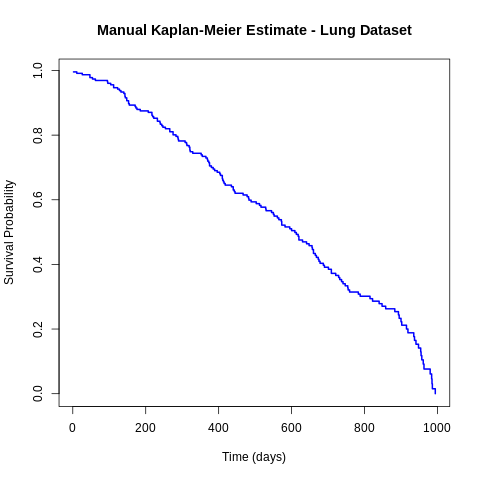

In [6]:
%%R
# Plot the survival curve
plot(km_table$time, km_table$survival, type = "s", col = "blue", lwd = 2,
     xlab = "Time (days)", ylab = "Survival Probability",
     main = "Manual Kaplan-Meier Estimate - Lung Dataset")

## Kaplan-Meier Estimator in R


This tutorial introduces survival analysis and how to conduct it in R. It primarily follows the Survival Analysis in R tutorials by [Emily C. Zabor](https://www.emilyzabor.com/tutorials/survival_analysis_in_r_tutorial.html) and [Joseph Rickert's](https://rviews.rstudio.com/2017/09/25/survival-analysis-with-r/) Survival Analysis in R tutorials.

This tutorial is mostly used two R packages [{survival}](https://cran.r-project.org/web/packages/survival/index.html) and [{ggsurvfit}](https://www.danieldsjoberg.com/ggsurvfit/). The survival package in R is a powerful and widely used tool for survival analysis, which deals with the analysis of time-to-event data. It provides a suite of functions to handle various types of survival data, fit survival models, and visualize survival curves. This package is widely applied in medical research, reliability engineering, and many other fields where time-to-event data is of interest.


![All-test](http://drive.google.com/uc?export=view&id=1THo0Z_LrFACx4jWa7FYkNgDtH3XEO8G6)



The {ggsurvfit} package eases the creation of time-to-event (aka survival) summary figures with {ggplot2}. The concise and modular code creates images that are ready for publication or sharing. Competing risks cumulative incidence is also supported via `ggcuminc()`.

Additionally we will use [{ggfortify}](https://github.com/sinhrks/ggfortify) which offers `fortify` and `autoplot` functions to allow automatic `ggplot2` to visualize Kaplan-Meier plots.


### Install Required R Packages


Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:


In [7]:
%%R
packages <-c(
		 'tidyverse',
		 'report',
		 'performance',
		 'gtsummary',
		 'MASS',
		 'epiDisplay',
		 'survival',
		 'survminer',
		 'ggsurvfit',
		 'tidycmprsk',
		 'ggfortify',
		 'timereg',
		 'cmprsk',
		 'riskRegression'
		 )


### Install missing packages

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')
devtools::install_github("ItziarI/WeDiBaDis")

In [ ]:
%%R
# Set library path again to ensure packages are installed in the correct location
.libPaths('drive/My Drive/R')

# Install the latest version of ggsurvfit
install.packages('ggsurvfit', lib='drive/My Drive/R/')

### Verify Installation

In [9]:
%%R
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method       from      
  print.lrtest epiDisplay

  method        from 
  nobs.multinom broom



     tidyverse         report    performance      gtsummary           MASS 
          TRUE           TRUE           TRUE           TRUE           TRUE 
    epiDisplay       survival      survminer      ggsurvfit     tidycmprsk 
          TRUE           TRUE           TRUE           TRUE           TRUE 
     ggfortify        timereg         cmprsk riskRegression 
          TRUE           TRUE           TRUE           TRUE 


### Load Packages

In [10]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))

In [11]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])

Successfully loaded packages:
 [1] "package:riskRegression" "package:cmprsk"         "package:timereg"       
 [4] "package:ggfortify"      "package:tidycmprsk"     "package:ggsurvfit"     
 [7] "package:survminer"      "package:ggpubr"         "package:epiDisplay"    
[10] "package:nnet"           "package:survival"       "package:foreign"       
[13] "package:MASS"           "package:gtsummary"      "package:performance"   
[16] "package:report"         "package:lubridate"      "package:forcats"       
[19] "package:stringr"        "package:dplyr"          "package:purrr"         
[22] "package:readr"          "package:tidyr"          "package:tibble"        
[25] "package:ggplot2"        "package:tidyverse"      "package:tools"         
[28] "package:stats"          "package:graphics"       "package:grDevices"     
[31] "package:utils"          "package:datasets"       "package:methods"       
[34] "package:base"          


### Data


We will be utilizing the `lung` dataset from the {survival} package, which serves as a valuable resource for analyzing survival data. This dataset comprises information from subjects diagnosed with advanced lung cancer, specifically gathered from the North Central Cancer Treatment Group, a prominent clinical trial network dedicated to cancer research.

Throughout this tutorial, we will concentrate on the following key variables that provide insight into the patients' demographics and clinical outcomes:

-   **Time**: This variable denotes the observed survival time in days, measuring the duration from the start of treatment until the event of interest occurs, whether that be death or censoring.

-   **Status**: This variable represents the censoring status of each patient. A value of 1 indicates that the patient is censored, meaning they either withdrew from the study or were still alive at the end of the observation period. A value of 2 signifies that the patient has died, marking the occurrence of the event being studied.

-   **Sex**: This variable captures the gender of the subjects, providing crucial demographic information. A value of 1 corresponds to Male and a value of 2 corresponds to Female. This distinction may be important for understanding potential differences in survival rates between genders.


In [12]:
%%R
# Load lung cancer dataset
data(lung)
glimpse(lung)

Rows: 228
Columns: 10
$ inst      <dbl> 3, 3, 3, 5, 1, 12, 7, 11, 1, 7, 6, 16, 11, 21, 12, 1, 22, 16…
$ time      <dbl> 306, 455, 1010, 210, 883, 1022, 310, 361, 218, 166, 170, 654…
$ status    <dbl> 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, …
$ age       <dbl> 74, 68, 56, 57, 60, 74, 68, 71, 53, 61, 57, 68, 68, 60, 57, …
$ sex       <dbl> 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, …
$ ph.ecog   <dbl> 1, 0, 0, 1, 0, 1, 2, 2, 1, 2, 1, 2, 1, NA, 1, 1, 1, 2, 2, 1,…
$ ph.karno  <dbl> 90, 90, 90, 90, 100, 50, 70, 60, 70, 70, 80, 70, 90, 60, 80,…
$ pat.karno <dbl> 100, 90, 90, 60, 90, 80, 60, 80, 80, 70, 80, 70, 90, 70, 70,…
$ meal.cal  <dbl> 1175, 1225, NA, 1150, NA, 513, 384, 538, 825, 271, 1025, NA,…
$ wt.loss   <dbl> NA, 15, 15, 11, 0, 0, 10, 1, 16, 34, 27, 23, 5, 32, 60, 15, …


### Data processing


Now we will re-code the data as 1=event, 0=censored:


In [13]:
%%R
lung <-
  lung |>
  mutate(
    status = recode(status, `1` = 0, `2` = 1)
  )


Now we have:

-   time: Observed survival time in days
-   status: censoring status 0=censored, 1=dead
-   sex: 1=Male, 2=Female


In [14]:
%%R
head(lung[, c("time", "status", "sex")])

  time status sex
1  306      1   1
2  455      1   1
3 1010      0   1
4  210      1   1
5  883      1   1
6 1022      0   1


### Kaplan Meier Analysis


The Kaplan-Meier method is the most common technique for estimating survival times and probabilities. It is a non-parametric approach that produces a step function, with a drop occurring each time an event takes place.

The {survival} package is fundamental to the entire R survival analysis framework. It is not only feature-rich but also essential for creating the object produced by the `Surv()` function, which includes data on failure times and censoring. Each subject will have a single entry representing their survival time, followed by a "+" sign if the subject was censored. Let’s examine the first 15 observations:


In [15]:
%%R
Surv(lung$time, lung$status)[1:15]

 [1]  306   455  1010+  210   883  1022+  310   361   218   166   170   654 
[13]  728    71   567 



Subject 1 experienced a notable event at 306 days of observation, indicating a significant outcome in their progression. Subject 2 had a similar event occur later, at 455 days, suggesting varying timelines in their responses. Meanwhile, subject 3 was censored at 1010 days, meaning that their outcome could not be fully assessed due to the study's conclusion or loss to follow-up. This variation among subjects highlights the differences in individual experiences and response times within the study.


The `Surv()` function in the {survival} package accepts by default `TRUE/FALSE`, where `TRUE` is event and `FALSE` is censored; 1/0 where 1 is event and 0 is censored; or 2/1 where 2 is event and 1 is censored.


The `survfit()` function plays a crucial role in survival analysis by generating survival curves based on the Kaplan-Meier method. This method is particularly useful for estimating the probability of survival over a specified time period, especially when dealing with censored data, which is common in medical research.

To initiate our analysis, we start with the formula `Surv(futime, status) ~ 1`, where `time` represents the follow-up time until the event of interest or censoring occurs, and `status` indicates whether the event happened (usually coded as 1) or if the data is censored (coded as 0). The `survfit()` function utilizes this formula to calculate the Kaplan-Meier estimates, providing a stepwise approximation of the survival function. Additionally, the `summary()` function complements this analysis by offering a detailed summary of the survival estimates. Within this function, the `times` parameter allows researchers to specify particular time points at which they wish to view the survival probabilities. This feature is beneficial for focusing on time intervals of interest, enhancing the interpretability of the survival curves. Overall, these tools are essential for understanding patient survival trajectories and can inform clinical decision-making and research developments.


In [16]:
%%R
km.fit<- survfit(Surv(time, status) ~ 1, data = lung)
str(km.fit)

List of 17
 $ n        : int 228
 $ time     : num [1:186] 5 11 12 13 15 26 30 31 53 54 ...
 $ n.risk   : num [1:186] 228 227 224 223 221 220 219 218 217 215 ...
 $ n.event  : num [1:186] 1 3 1 2 1 1 1 1 2 1 ...
 $ n.censor : num [1:186] 0 0 0 0 0 0 0 0 0 0 ...
 $ surv     : num [1:186] 0.996 0.982 0.978 0.969 0.965 ...
 $ std.err  : num [1:186] 0.0044 0.00885 0.00992 0.01179 0.01263 ...
 $ cumhaz   : num [1:186] 0.00439 0.0176 0.02207 0.03103 0.03556 ...
 $ std.chaz : num [1:186] 0.00439 0.0088 0.00987 0.01173 0.01257 ...
 $ type     : chr "right"
 $ logse    : logi TRUE
 $ conf.int : num 0.95
 $ conf.type: chr "log"
 $ lower    : num [1:186] 0.987 0.966 0.959 0.947 0.941 ...
 $ upper    : num [1:186] 1 1 0.997 0.992 0.989 ...
 $ t0       : num 0
 $ call     : language survfit(formula = Surv(time, status) ~ 1, data = lung)
 - attr(*, "class")= chr "survfit"



This model is designed to generate estimates for 1, 30, 60, and 90 days, and then every 90 days thereafter. It is the simplest possible model, requiring just three lines of R code to fit and produce both numerical and graphical summaries.


In [17]:
%%R
summary(km.fit, times = c(1,30,60,90*(1:10)))

Call: survfit(formula = Surv(time, status) ~ 1, data = lung)

 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    1    228       0   1.0000  0.0000       1.0000        1.000
   30    219      10   0.9561  0.0136       0.9299        0.983
   60    213       7   0.9254  0.0174       0.8920        0.960
   90    201      10   0.8816  0.0214       0.8406        0.925
  180    160      36   0.7217  0.0298       0.6655        0.783
  270    108      30   0.5753  0.0338       0.5128        0.645
  360     70      24   0.4340  0.0358       0.3693        0.510
  450     48      16   0.3287  0.0356       0.2659        0.406
  540     33      10   0.2554  0.0344       0.1962        0.333
  630     22       7   0.1958  0.0330       0.1407        0.272
  720     14       8   0.1246  0.0290       0.0789        0.197
  810      7       5   0.0783  0.0246       0.0423        0.145
  900      3       2   0.0503  0.0228       0.0207        0.123


### Kaplan-Meier plots


We will use the {ggsurvfit} package to generate Kaplan-Meier plots. This package simplifies the plotting of time-to-event endpoints by leveraging the capabilities of the {ggplot2} package. The {ggsurvfit} package works best when you create the survival object using the included `ggsurvfit::survfit2()` function. This function uses the same syntax as `survival::survfit()`, but `ggsurvfit::survfit2()` tracks the environment from the function call, which helps the plot have better default values for labeling and p-value reporting.


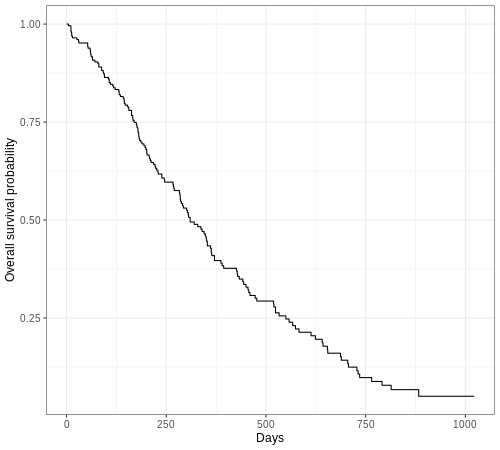

In [18]:
%%R -w 500 -h 450 -u px
survfit2(Surv(time, status) ~ 1, data = lung) |>
  ggsurvfit() +
  labs(
    x = "Days",
    y = "Overall survival probability"
  )



The default plot in `ggsurvfit()` shows the step function only. We can add the confidence interval using `add_confidence_interval()`:


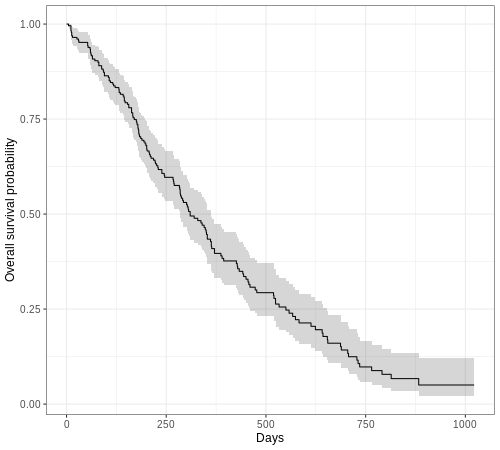

In [19]:
%%R -w 500 -h 450 -u px
survfit2(Surv(time, status) ~ 1, data = lung) |>
  ggsurvfit() +
  labs(
    x = "Days",
    y = "Overall survival probability"
  ) +
 add_confidence_interval()


If we want to display the numbers at risk below the x-axis, we can achieve this by using `add_risktable()` :



Alternatively, the **ggfortify** package allows you to create a simple survival plot with CI using the `autoplot()` function.


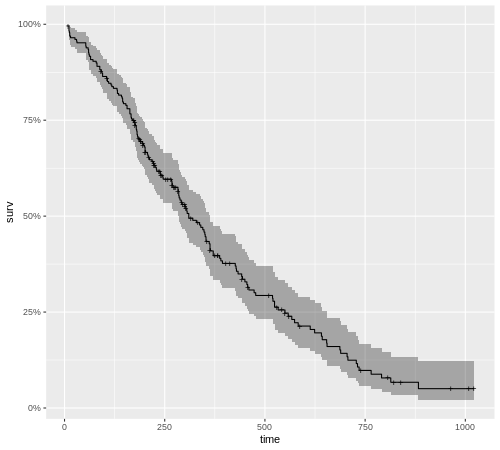

In [20]:
%%R -w 500 -h 450 -u px
autoplot(km.fit)

### Estimating $x$-year survival


In survival analysis, one key point of interest is the probability of surviving beyond a specific number of years. For instance, to estimate the probability of surviving up to one year, you can use the summary function with the times argument. Note that the time variable in the lung dataset is measured in days, so you should set times to 365.25.


In [21]:
%%R
summary(survfit(Surv(time, status) ~ 1, data = lung), times = 365.25)

Call: survfit(formula = Surv(time, status) ~ 1, data = lung)

 time n.risk n.event survival std.err lower 95% CI upper 95% CI
  365     65     121    0.409  0.0358        0.345        0.486


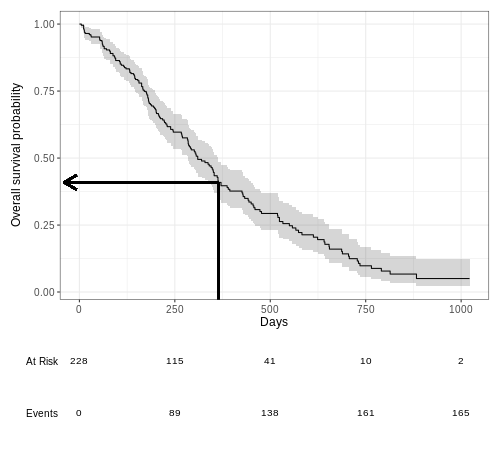

In [22]:
%%R -w 500 -h 450 -u px
survfit2(Surv(time, status) ~ 1, data = lung)  |>
  ggsurvfit() +
  labs(
    x = "Days",
    y = "Overall survival probability"
  ) +
 add_confidence_interval() +
   add_risktable(risktable_height = 0.25) +
  geom_segment(x = 365.25, xend = 365.25, y = -0.05, yend = 0.4092416,
               linewidth = 1.0) +
  geom_segment(x = 365.25, xend = -40, y = 0.4092416, yend = 0.4092416,
               linewidth = 1.0,
               arrow = arrow(length = unit(0.2, "inches")))


By one year, 121 of the 228 lung patients had died, and if we ignore censoring, the one year probability of survival:


In [23]:
%%R
(1-121/228)*100

[1] 46.92982



Ignoring the fact that 42 patients were censored before the one-year mark can lead to an inaccurate estimate of the one-year probability of survival (47%). The correct estimate, which takes censoring into account using the Kaplan-Meier method, is 41%. Ignoring censoring results in an overestimation of the overall survival probability. Consider two studies, each with 228 subjects, where both have 165 deaths. In one study (represented by the blue line), censoring is ignored, while in the other (shown by the yellow line), censoring is taken into account. Censored subjects only provide information for part of the follow-up period and then drop out of the risk set, which leads to a lower cumulative probability of survival. Ignoring censoring incorrectly assumes that censored patients remain part of the risk set for the entire follow-up period.


Joining with `by = join_by(inst, time, status, age, sex, ph.ecog, ph.karno,
pat.karno, meal.cal, wt.loss, group)`


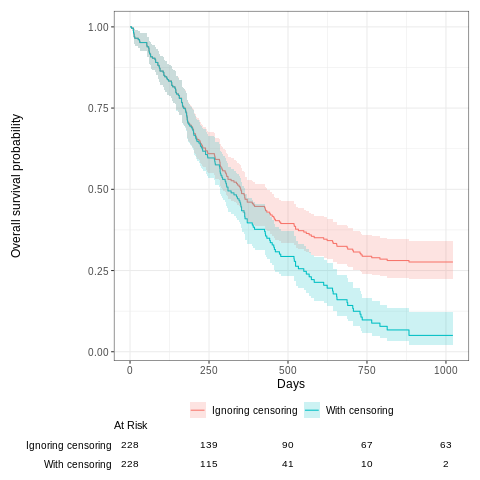

In [24]:
%%R
lung2 <-
  lung |>
  mutate(
    time = ifelse(status == 1, time, 1022),
    group = "Ignoring censoring") |>
  full_join(mutate(lung, group = "With censoring"))

survfit2(Surv(time, status) ~ group, data = lung2) |>
  ggsurvfit() +
  labs(
    x = "Days",
    y = "Overall survival probability"
    ) +
  add_confidence_interval() +
  add_risktable(risktable_stats = "n.risk")


We can produce nice tables of $x$-time survival probability estimates using the `tbl_survfit()` function from the {gtsummary} package:


In [25]:
%%R
tbl_survfit(
  survfit(Surv(time, status) ~ 1, data = lung),
  times = 365.25,
  label_header = "**1-year survival (95% CI)**"
) %>%
  as_tibble()

# A tibble: 1 × 2
  `**Characteristic**` `**1-year survival (95% CI)**`
  <chr>                <chr>                         
1 Overall              41% (34%, 49%)                


### Median survival time


In survival analysis, one important point to consider is the average survival time, which we typically measure using the median. Since survival times are usually not normally distributed, using the mean is not an appropriate way to summarize this data.

The median survival time can be directly obtained from the `survfit()` object.


In [26]:
%%R
survfit(Surv(time, status) ~ 1, data = lung)

Call: survfit(formula = Surv(time, status) ~ 1, data = lung)

       n events median 0.95LCL 0.95UCL
[1,] 228    165    310     285     363



We can create appealing tables displaying the median survival time estimates using the `tbl_survfit()` function from the {gtsummary} package.


In [27]:
%%R
survfit(Surv(time, status) ~ 1, data = lung) %>%
  tbl_survfit(
    probs = 0.5,
    label_header = "**Median survival (95% CI)**"
  ) %>%
  as_tibble()

# A tibble: 1 × 2
  `**Characteristic**` `**Median survival (95% CI)**`
  <chr>                <chr>                         
1 Overall              310 (285, 363)                


### Survival times between groups (male/female) using log-rank test


The log-rank test is a non-parametric statistical method used to compare the survival distributions of two or more groups. It assesses whether there is a significant difference between the survival curves by giving equal weight to observations throughout the entire follow-up period.

To calculate the log-rank p-value, we can use the **survdiff()** function. For example, we can test for differences in survival time based on sex using the **lung** dataset.


In [28]:
%%R
survdiff(Surv(time, status) ~ sex, data = lung)

Call:
survdiff(formula = Surv(time, status) ~ sex, data = lung)

        N Observed Expected (O-E)^2/E (O-E)^2/V
sex=1 138      112     91.6      4.55      10.3
sex=2  90       53     73.4      5.68      10.3

 Chisq= 10.3  on 1 degrees of freedom, p= 0.001 



There is a significant difference in overall survival by sex in the lung data, with a p-value of 0.001.

Next, we look at survival curves by sex.


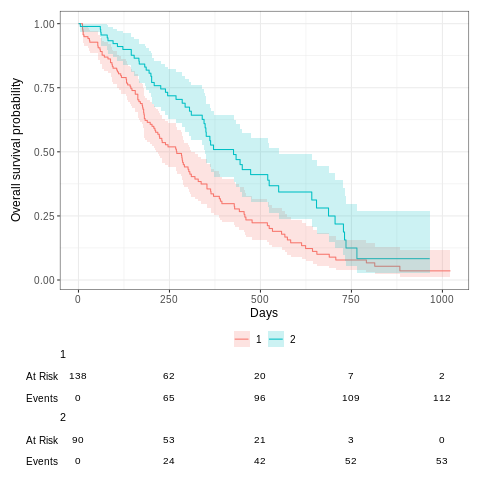

In [29]:
%%R
survfit2(Surv(time, status) ~ sex, data = lung) |>
  ggsurvfit() +
  labs(
    x = "Days",
    y = "Overall survival probability"
  ) +
  add_confidence_interval() +
  add_risktable()

## Summary and Conclusion


**Nonparametric survival analysis**, especially using the **Kaplan-Meier estimator** and **log-rank test**, is a powerful tool for analyzing time-to-event data, particularly in situations where the distribution of survival times is unknown and when censoring is present. These techniques allow researchers to estimate and compare survival probabilities between groups, providing a foundation for more advanced survival analysis methods.

These methods are fundamental in fields like clinical research, reliability engineering, and economics, where time-to-event outcomes and censored data are prevalent.


## Resources


1.  [Survival Analysis with R](https://rviews.rstudio.com/2017/09/25/survival-analysis-with-r/)

2.  [Survival data analysis](https://www.karlin.mff.cuni.cz/~pesta/NMFM404/survival.html)

3.  [Survival Analysis in R](https://www.emilyzabor.com/tutorials/survival_analysis_in_r_tutorial.html)

4.  [Survival Analysis with R](https://bioconnector.github.io/workshops/r-survival.html)

5.  [Survival Analysis in R Companion](https://www.drizopoulos.com/courses/emc/basic_surivival_analysis_in_r)

6.  [Survival Analysis in R](https://www.themillerlab.io/posts/survival_analysis/)